In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [2]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
## get data, just Close values
import readcsv
data = readcsv.get_data(cols=['Close'], verbose=False).astype(np.float32)
print(data.shape)

(18628, 54)


In [4]:
## indicators to use when training
#keeplist = [0, 1, 5, 15, 16, 25, 27]
#keeplist = [0]

In [4]:
## ===== Preprocessing ==============================
## scale all data into interval [0, 1]
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

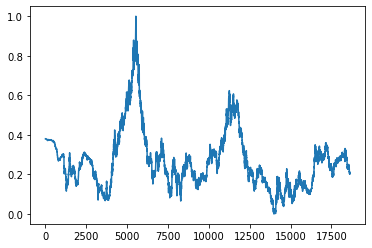

In [6]:
## visualize data
plt.plot(data[:, 0])
plt.show()

In [29]:
## fit on cosine
#data = np.cos(2*np.pi*np.arange(18000)/25).reshape(-1, 1)
#print(data.shape)

(18000, 1)


In [7]:
def generate_batches(data, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X: shape = (B, len(learn_window), C)
    - y: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    predict_window = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window]
        y[k] = data[i+Lcap+predict_window, 0] ## USD-EUR Close is index 0
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, 7, np.arange(50), np.arange(5))

X, y = next(G)
print(X.shape)
print(y.shape)

(7, 50, 54)
(7, 5)


# Predict next day
Given 30-day history of USD-EUR closing, predict next day closing.
Should expect good performance since linear regression is pretty good at this.

In [7]:
## split into training and testing sets
data_train = data[:-2000, 0:1]
data_test = data[-2000:, 0:1]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)

Training: (16628, 1)
Testing: (2000, 1)


In [8]:
## ===== model hyperparameters ======================
learn_window = np.arange(30)    ## learn from past 30 days
predict_window = np.arange(1)   ## predict next day

batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_1d = models.Sequential()
model_1d.add(layers.GRU(64, input_shape=(L, C)))
model_1d.add(layers.Dense(P))
model_1d.compile(optimizer=opt, loss='mse')
model_1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [9]:
## generate test data
G = generate_batches(data_test, 100, learn_window, predict_window)
X_test, y_test = next(G)

In [10]:
## train on one data point as test
G = generate_batches(data_train, 1, learn_window, predict_window)
X, y = next(G)

model_1d.fit(X, y, batch_size=1)
model_1d.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 1s/sample - loss: 0.0638


0.06375278532505035

In [11]:
## train!
G = generate_batches(data_train, batch_size, learn_window, predict_window)

model_1d.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_test, y_test))

Train for 300 steps, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 38s 127ms/step - loss: 0.0018 - val_loss: 2.6782e-05
Epoch 2/10
300/300 [==============================] - 32s 106ms/step - loss: 5.7057e-05 - val_loss: 2.5030e-05
Epoch 3/10
300/300 [==============================] - 27s 92ms/step - loss: 4.9029e-05 - val_loss: 2.3979e-05
Epoch 4/10
300/300 [==============================] - 28s 92ms/step - loss: 4.6758e-05 - val_loss: 2.0658e-05
Epoch 5/10
300/300 [==============================] - 28s 93ms/step - loss: 4.3207e-05 - val_loss: 2.1052e-05
Epoch 6/10
300/300 [==============================] - 25s 84ms/step - loss: 4.2412e-05 - val_loss: 2.5603e-05
Epoch 7/10
300/300 [==============================] - 25s 84ms/step - loss: 3.9842e-05 - val_loss: 2.5316e-05
Epoch 8/10
300/300 [==============================] - 30s 100ms/step - loss: 4.1096e-05 - val_loss: 1.8151e-05
Epoch 9/10
300/300 [==============================] - 30s 99ms/step - loss: 

comment: it looks like validation loss is less than training loss. This is actually due to the fact that the training data is just harder to model than the testing data. This is not a bug, since if I validate on the testing data I get roughly similar losses. At least, this assures us that our model is not overfitting. Also, the training loss is a running average over the epoch, so is over-estimated in the beginning.

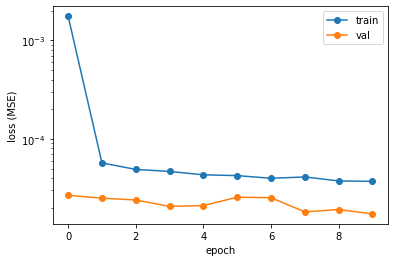

In [12]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [18]:
## test on all testing data
N, C = data_test.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i

X_learn = np.zeros((M, L, C))
y_detail = np.zeros((M, Pcap))
y_predict = np.zeros((M, P))

for i in range(M):
    X_learn[i] = data_test[i+learn_window]
    y_detail[i] = data_test[i+Lcap+predict_window, 0]

y_predict = model_1d.predict(X_learn)

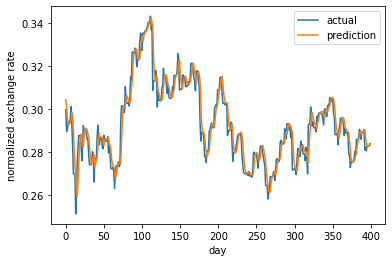

Average MSE: 1.855e-05


In [24]:
## visualize predictions

## pick any date interval, subset of [0, M]
dates = np.arange(0, 400)
#dates = np.arange(0, M)

plt.plot(y_detail[dates, 0], label='actual')
plt.plot(y_predict[dates, 0], label='prediction')
plt.ylabel('normalized exchange rate')
plt.xlabel('day')
plt.legend()
plt.show()

ave_mse = np.mean(np.square(y_detail[:,0] - y_predict[:,0]))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE: %.3e" % ave_mse)

This is similar to linear regression, which has an average MSE = 1.046e-05 over the same dataset

# Predict future trend
Given 100-day USD-EUR closing, predict next 30-days. Try to beat linear regression predictions

In [8]:
## split into training and testing sets
#data_train = data[:-2000, keeplist]
#data_test = data[-2000:, keeplist]
data_train = data[:-2000]
data_test = data[-2000:]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)

Training: (16628, 54)
Testing: (2000, 54)


In [9]:
## ===== model hyperparameters ======================
learn_window = np.arange(30)
predict_window = np.array([0, 5, 10])
batch_size = 10
initial_learning_rate = 1e-3
decay_steps = 500
decay_rate = 0.9
## ==================================================

_, C = data_train.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_trend = models.Sequential()
model_trend.add(layers.GRU(100, kernel_regularizer='l1', return_sequences=True, input_shape=(L, C)))
model_trend.add(layers.Dropout(0.2))
model_trend.add(layers.GRU(100, return_sequences=True))
model_trend.add(layers.Dropout(0.2))
model_trend.add(layers.GRU(100))
model_trend.add(layers.Dropout(0.2))
model_trend.add(layers.Dense(P))
model_trend.compile(optimizer=opt, loss='mae')
model_trend.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 100)           46800     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 100)           60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3

In [11]:
## reduce all input weights not accociated with USD-EUR to 0
weights = model_trend.layers[0].get_weights()
weights[0][1:] /= 1e3
model_trend.layers[0].set_weights(weights)

In [12]:
## generate test data
G = generate_batches(data_test, 100, learn_window, predict_window)
X_test, y_test = next(G)

In [13]:
## train on one data point as test
G = generate_batches(data_train, 1, learn_window, predict_window)
X, y = next(G)

model_trend.fit(X, y, batch_size=1)
model_trend.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 3s 3s/sample - loss: 0.5244


0.5243961811065674

In [19]:
## train!
G = generate_batches(data_train, batch_size, learn_window, predict_window)

model_trend.fit(G, steps_per_epoch=500, epochs=50, validation_data=(X_test, y_test))

Train for 500 steps, validate on 100 samples
Epoch 1/20
500/500 [==============================] - 103s 205ms/step - loss: 0.0171 - val_loss: 0.0134
Epoch 2/20
500/500 [==============================] - 95s 189ms/step - loss: 0.0171 - val_loss: 0.0113
Epoch 3/20
500/500 [==============================] - 99s 198ms/step - loss: 0.0165 - val_loss: 0.0141
Epoch 4/20
500/500 [==============================] - 98s 197ms/step - loss: 0.0165 - val_loss: 0.0116
Epoch 5/20
500/500 [==============================] - 104s 208ms/step - loss: 0.0167 - val_loss: 0.0110
Epoch 6/20
500/500 [==============================] - 96s 192ms/step - loss: 0.0166 - val_loss: 0.0124
Epoch 7/20
500/500 [==============================] - 95s 191ms/step - loss: 0.0164 - val_loss: 0.0133
Epoch 8/20
500/500 [==============================] - 94s 188ms/step - loss: 0.0163 - val_loss: 0.0107
Epoch 9/20
500/500 [==============================] - 94s 187ms/step - loss: 0.0163 - val_loss: 0.0119
Epoch 10/20
500/500 [=====

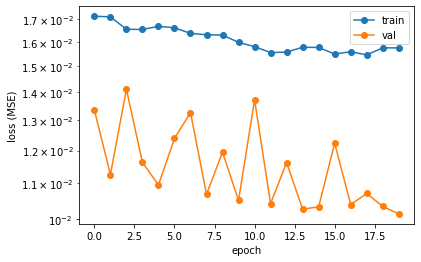

In [20]:
train_loss = model_trend.history.history['loss']
val_loss = model_trend.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [21]:
N, C = data_test.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap # ceiling for i

In [22]:
## test on all testing data

detail_window = np.arange(Pcap)

X_learn = np.zeros((M, L, C))
y_detail = np.zeros((M, Pcap))
y_predict = np.zeros((M, P))

for i in range(M):
    X_learn[i] = data_test[i+learn_window]
    y_detail[i] = data_test[i+Lcap+detail_window, 0]

y_predict = model_trend.predict(X_learn)

stream = np.zeros(M)
for i in range(M):
    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
    scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    mse *= scale_factor
    
    stream[i] = mse*scale_factor
    
print("Average MSE: %.3e" % np.mean(stream))

Average MSE: 7.955e-05


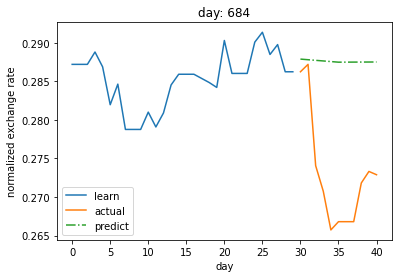

MSE: 2.011e-04


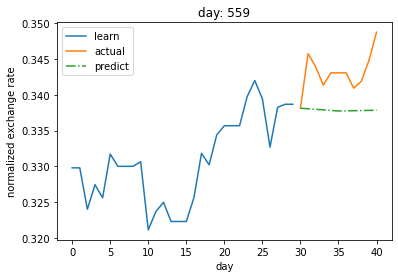

MSE: 4.573e-05


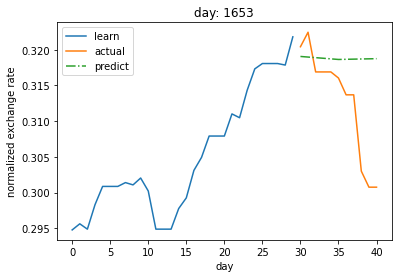

MSE: 1.036e-04


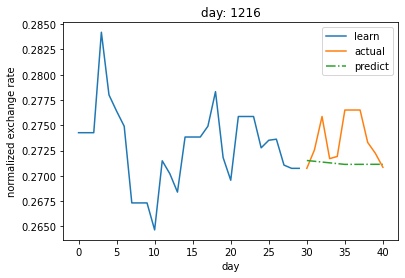

MSE: 9.235e-06


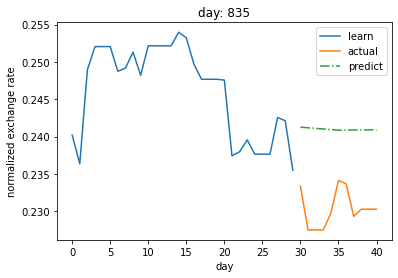

MSE: 6.891e-05


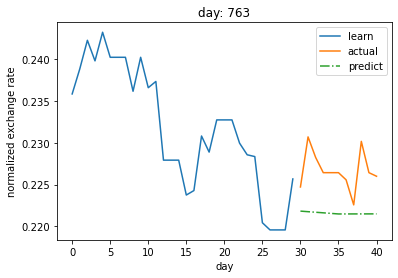

MSE: 1.647e-05


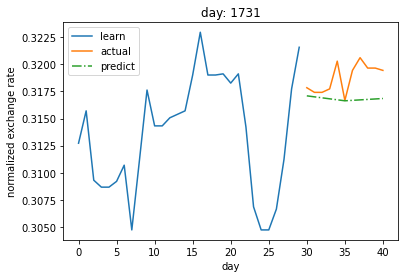

MSE: 2.281e-06


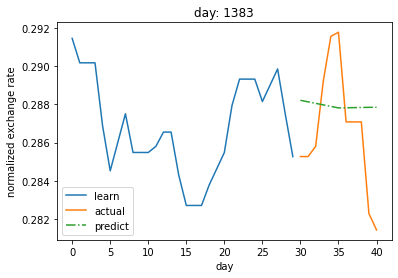

MSE: 2.053e-05


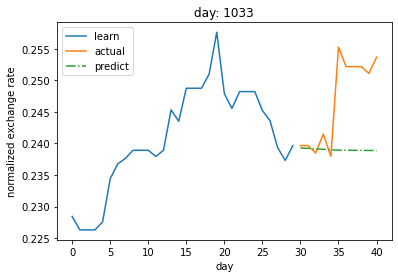

MSE: 1.513e-04


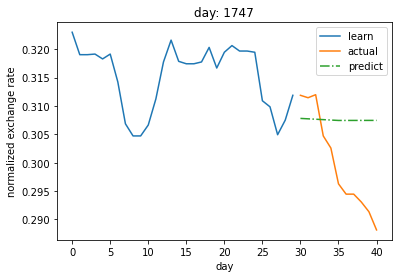

MSE: 1.602e-04


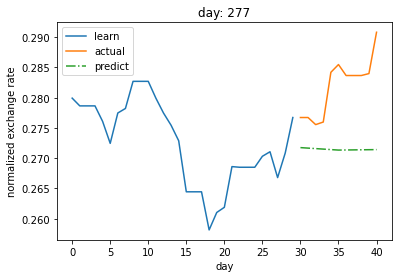

MSE: 1.877e-04


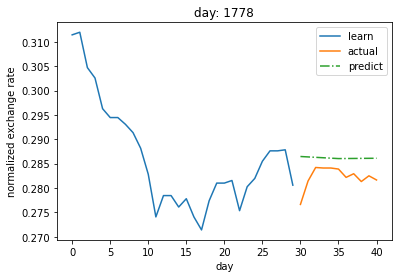

MSE: 3.787e-05


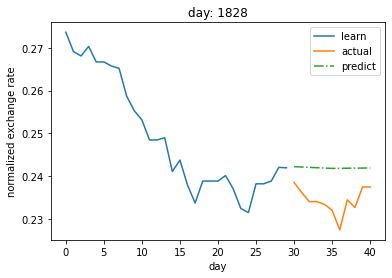

MSE: 4.041e-05


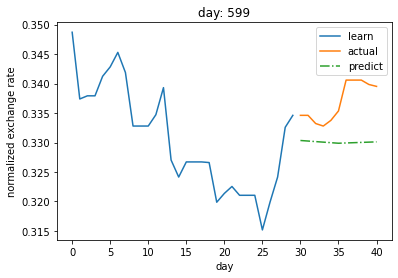

MSE: 4.271e-05


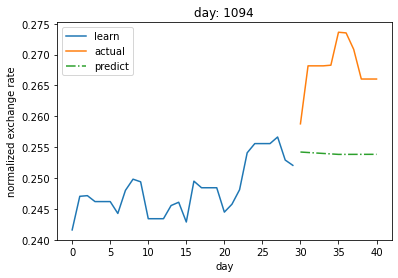

MSE: 1.754e-04


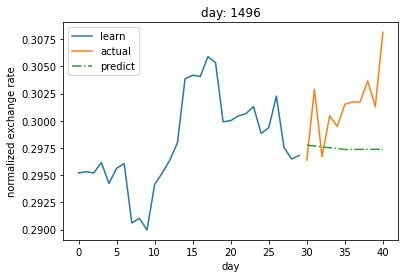

MSE: 4.200e-05


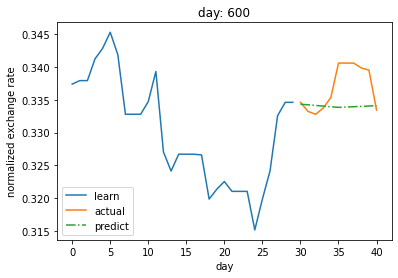

MSE: 1.437e-05


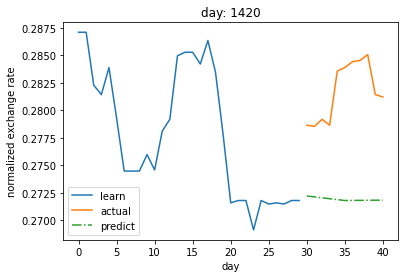

MSE: 8.573e-05


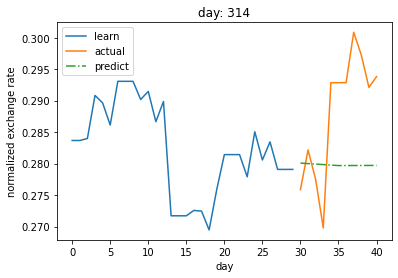

MSE: 1.217e-04


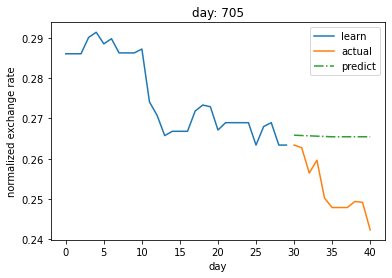

MSE: 2.645e-04


In [23]:
## visualize predictions
np.random.seed(0)
for i in np.random.randint(0, M, size=20):
    
    plt.plot(learn_window, X_learn[i, :, 0], label='learn')
    plt.plot(Lcap+detail_window, y_detail[i], label='actual')
    plt.plot(Lcap+predict_window, y_predict[i], '-.', label='predict')
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_detail[i, predict_window] - y_predict[i]))
    scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    mse *= scale_factor
    
    print("MSE: %.3e" % mse)

Seems that model just predicts a straight line. While this loss is technically lower than that of linear regression (Average MSE=2.530e-04 on same dataset), I don't think the model is learning anything meaningful. It is learning some sort of "jaggedness" from the data, however.

# Testing Code

In [ ]:
def test_generate_batches():
    data = np.arange(1000).reshape(-1, 1)
    print(data.shape)
    
    G = generate_batches(data, 1, [0, 10, 20, 30], [0, 10, 20, 30])
    
    for i in range(10):
        X, y = next(G)
        print(X[0,:,0], y[0])

test_generate_batches()